### Identify misinformation using Knowledge Graphs.

Knowledge graphs are scalable and better way to store the factual/misinformation.

We build KG for both of the following:
1. For true and verified information
2. For false/fake information

We have (nodeA, relation, nodeB) type of edges in the knowledge graph. Each edge has an associated confidence value which can range from -1 to +1; -1 shows that the relations is mostly false, whereas 0 shows that the relation may be true or false and +1 denotes that the information can be trusted.

Here I provide a proof-of-concept of how this method of datastore can be used to identify misinformation.

In [1]:
import re, nltk
from tqdm import tqdm
import scipy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from newspaper import Article
from IPython.display import display, HTML

%matplotlib inline

In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

### How to Build Knowledge Graphs?

1. Build some trustworthy news sites or sources. Put a trust rank (similar to page rank in Google) for the sites. More trusted sites have the higher rank, and the sites publishing more fake content have the lesser trust rank. 

2. Use a scraper like below (or BeautifulSoup) to get the most-recent articles from the trusted sites and most untrusted sites to build the Knowledge Graph.

In [3]:
article = Article(url = 'https://www.cnn.com/2020/05/06/health/coronavirus-inflammatory-children-uk-health/index.html')
article.download()
article.parse()
article.text

'(CNN) Researchers in the UK said Wednesday they have seen an "unprecedented cluster" of eight children with rare inflammatory problems amid the coronavirus pandemic.\n\nThe cases, they said, resemble a severe form of Kawasaki disease -- a rare condition that causes inflammation in the walls of the arteries and can limit blood flow to the heart.\n\nSeparately on Wednesday, the New York State Department of Health reported 64 suspected cases of a similar syndrome, which they called "Pediatric Multi-System Inflammatory Syndrome Associated with COVID-19."\n\nIn the British study, all of the children were previously fit and well, according to Shelley Riphagen and colleagues at Evelina London Children\'s Hospital. Five of the children received mechanical ventilation through a tube in the windpipe, and one who needed extracorporeal membrane oxygenation or ECMO -- a device that takes over for the heart and lungs—later died of a stroke.\n\nFour of the children had known exposure to coronavirus,

### Processing the data store

Next we process the articles to get the keywords. For this, we can use "spacy". Since this package newspaper has in-built nlp module, I demonstrate the same using it.

In [4]:
article.nlp()
print(article.keywords)

['rare', 'syndrome', 'coronavirus', 'unprecedented', 'problems', 'researchers', 'inflammatory', 'cluster', 'children', 'walls', 'york', 'pandemic', 'amid', 'report', 'windpipe', 'cases', 'ventilation']


In [5]:
sentences = []

sent_text = nltk.sent_tokenize(article.text)
sentences.extend(sent_text)

In [6]:
vocabulary = {k: v for v, k in enumerate(article.keywords)}
rev_vocab = {v: k for k, v in vocabulary.items()}

For the proof-of-concept, I consider two keywords are related if they are occurring in the same sentence. In the actual prototype, we can consider getting some meaningful relations.

In [7]:
def create_cooccurrence_matrix(sentences, vocabulary, window_size=100):
    data = []
    row = []
    col = []

    vocabs = [r'\b' + elem + r'\b' for elem in vocabulary.keys()]
    pattern = re.compile("|".join(vocabs))
    
    for sentence in sentences:
        sentence = sentence.strip()
        sentence = re.sub(re.escape(')'), '', sentence)
        sentence = re.sub(re.escape('('), '', sentence)
        sentence = re.sub(re.escape('['), '', sentence)
        sentence = re.sub(re.escape(']'), '', sentence)
        sentence = re.sub(re.escape('.'), '', sentence)
        sentence = re.sub(re.escape('*'), '', sentence)
        
        tokens = pattern.findall(sentence)
        tokens = [token for token in tokens if token in vocabulary.keys()]
        
        for pos, token in enumerate(tokens):
            i = vocabulary.setdefault(token, len(vocabulary))
            
            start = 0
            end = len(tokens)
            
            for pos2 in range(start, end):
                if pos2 == pos:
                    continue
                    
                j = vocabulary.setdefault(tokens[pos2], len(vocabulary))
                data.append(1.)
                row.append(i)
                col.append(j)

    cooccurrence_matrix_sparse = scipy.sparse.coo_matrix((data, (row, col)), shape=[len(vocabulary), len(vocabulary)])
    return vocabulary, cooccurrence_matrix_sparse

In [8]:
vocabs, co_occ = create_cooccurrence_matrix(sentences, vocabulary)

KnowledgeBase = pd.DataFrame(co_occ.todense(),
                             index = vocabs.keys(),
                             columns = vocabs.keys())

In [9]:
KnowledgeBase

,rare,syndrome,coronavirus,unprecedented,problems,researchers,inflammatory,cluster,children,walls,york,pandemic,amid,report,windpipe,cases,ventilation
rare,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
coronavirus,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
unprecedented,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
problems,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
researchers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inflammatory,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
cluster,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
children,1.0,0.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
walls,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
tuples = []
sources = []
targets = []
relations = []
confidences = []

for key, numkey, value in zip(co_occ.row, co_occ.col, co_occ.data):
        if value > 0:
            if rev_vocab[key] == rev_vocab[numkey]:
                continue
                
            if (rev_vocab[key], rev_vocab[numkey]) not in tuples and (rev_vocab[numkey], rev_vocab[key]) not in tuples:
                tuples.append((rev_vocab[key], rev_vocab[numkey]))
                sources.append(rev_vocab[key])
                relations.append('ASSOCIATION')
                targets.append(rev_vocab[numkey])
                confidences.append(value)

In [11]:
TruePairs = pd.DataFrame({'source':sources, 'target':targets, 'relation': relations, 'edge':confidences})
TruePairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   source    43 non-null     object 
 1   target    43 non-null     object 
 2   relation  43 non-null     object 
 3   edge      43 non-null     float64
dtypes: float64(1), object(3)
memory usage: 1.5+ KB


### Knowledge Graph Construction for True information

In [12]:
def draw_kg(pairs, real):
    k_graph = nx.from_pandas_edgelist(pairs, 'source', 'target', create_using = nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k = 0.15, iterations = 20)
    plt.figure(num = None, figsize = (15, 15), dpi=80)
    
    if real:
        nx.draw_networkx(
            k_graph,
            node_size = [int(deg[1]) * 500 for deg in node_deg],
            arrowsize = 20,
            linewidths = 1.5,
            pos = layout,
            edge_color = 'green',
            edgecolors = 'black',
            node_color = 'white')

        labels = dict(zip(list(zip(pairs.source, pairs.target)), pairs['edge'].tolist()))
        nx.draw_networkx_edge_labels(k_graph, pos = layout, edge_labels = labels, font_color = 'green')
    else:
        nx.draw_networkx(
            k_graph,
            node_size = [int(deg[1]) * 500 for deg in node_deg],
            arrowsize = 20,
            linewidths = 1.5,
            pos = layout,
            edge_color = 'red',
            edgecolors = 'black',
            node_color = 'white')

        labels = dict(zip(list(zip(pairs.source, pairs.target)), pairs['edge'].tolist()))
        nx.draw_networkx_edge_labels(k_graph, pos = layout, edge_labels = labels, font_color = 'red')        
        
    plt.axis('off')
    plt.show()

For now here, edge weights are given the value of the counts of co-occurrence.

But, in the actual prototype; the expectation is that the edge weights would be equal to the confidence of the relation i.e., more the relation is seen in the trusted articles, more is the confidence of the relation.

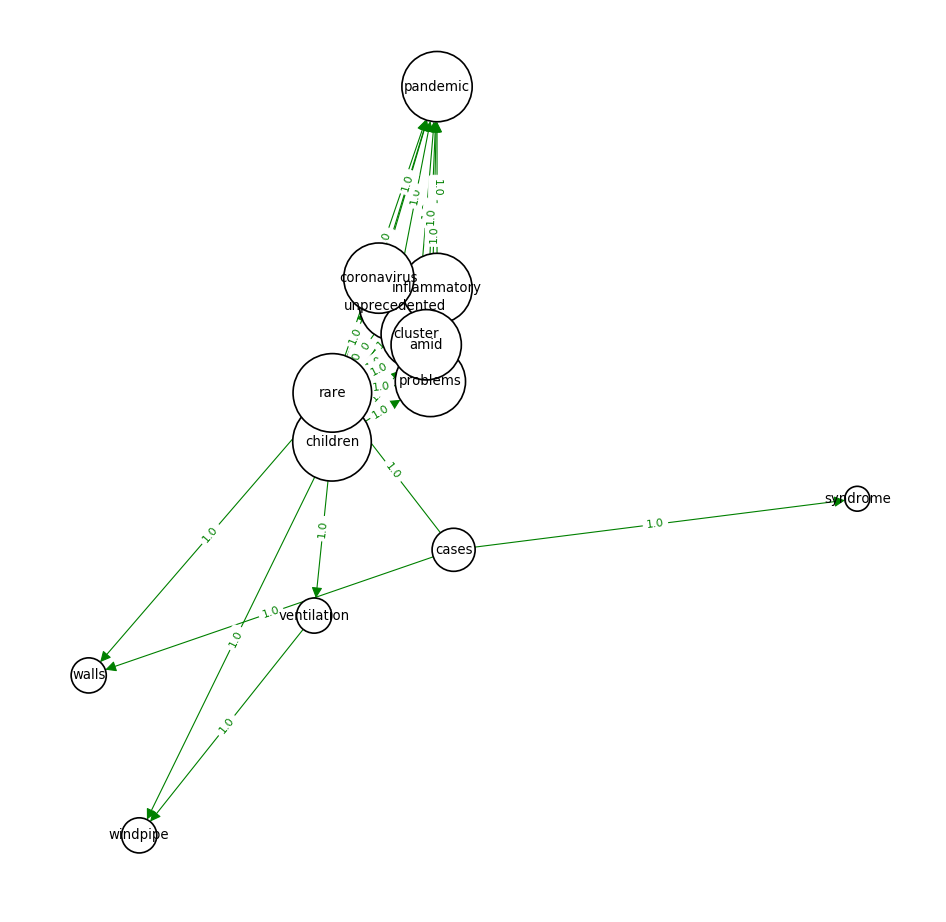

In [13]:
draw_kg(TruePairs, True)

### Knowledge Graph for the Fake information

Here the edge weight gives how much incorrect the information is: i.e., more the edgeweight, then more inaccurate the relation is, and it is more likely that any news article with this relation is fake.

In [14]:
article = Article(url = 'https://www.politifact.com/factchecks/2020/may/22/janel-brandtjen/yes-children-do-get-coronavirus-it-just-might-not-/')

article.download()
article.parse()
article.nlp()

vocabulary = {k: v for v, k in enumerate(article.keywords)}
rev_vocab = {v: k for k, v in vocabulary.items()}

sentences = []

sent_text = nltk.sent_tokenize(article.text)
sentences.extend(sent_text)

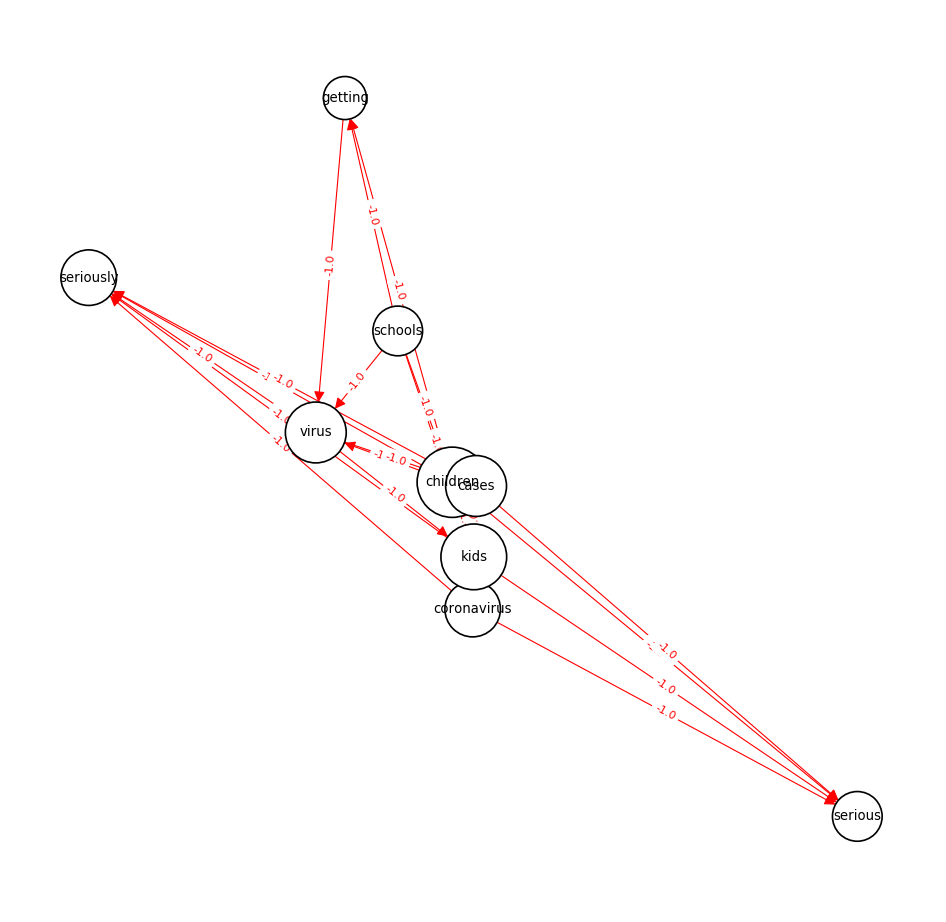

In [15]:
vocabs, co_occ = create_cooccurrence_matrix(sentences, vocabulary)

tuples = []
sources = []
targets = []
relations = []
confidences = []

for key, numkey, value in zip(co_occ.row, co_occ.col, co_occ.data):
        if value > 0:
            if rev_vocab[key] == rev_vocab[numkey]:
                continue
                
            if (rev_vocab[key], rev_vocab[numkey]) not in tuples and (rev_vocab[numkey], rev_vocab[key]) not in tuples:
                tuples.append((rev_vocab[key], rev_vocab[numkey]))
                sources.append(rev_vocab[key])
                relations.append('ASSOCIATION')
                targets.append(rev_vocab[numkey])
                confidences.append(-1 * value)
                
FalsePairs = pd.DataFrame({'source':sources, 'target':targets, 'relation': relations, 'edge':confidences})

draw_kg(FalsePairs, False)

## Data Store

Data is stored in the following way (keywordA, keywordB, relation, confidence)

In [16]:
display(TruePairs)
display(FalsePairs)

,source,target,relation,edge
0,unprecedented,cluster,ASSOCIATION,1.0
1,unprecedented,children,ASSOCIATION,1.0
2,unprecedented,rare,ASSOCIATION,1.0
3,unprecedented,inflammatory,ASSOCIATION,1.0
4,unprecedented,problems,ASSOCIATION,1.0
5,unprecedented,amid,ASSOCIATION,1.0
6,unprecedented,coronavirus,ASSOCIATION,1.0
7,unprecedented,pandemic,ASSOCIATION,1.0
8,cluster,children,ASSOCIATION,1.0
9,cluster,rare,ASSOCIATION,1.0


,source,target,relation,edge
0,children,virus,ASSOCIATION,-1.0
1,children,cases,ASSOCIATION,-1.0
2,virus,cases,ASSOCIATION,-1.0
3,children,serious,ASSOCIATION,-1.0
4,children,coronavirus,ASSOCIATION,-1.0
5,children,seriously,ASSOCIATION,-1.0
6,coronavirus,cases,ASSOCIATION,-1.0
7,coronavirus,seriously,ASSOCIATION,-1.0
8,cases,seriously,ASSOCIATION,-1.0
9,schools,children,ASSOCIATION,-1.0


### Identifying if a new found information is fake/real.

I intend to use the following methos to score the new found information.

1. First step is to find out the relation pairs.
2. For each relation in the real Knowledge Graph, increase the score by 1 * (confidence of the veracity) i.e., edge-weight of the relation
3. For each relation in the fake Knowledge Graph, decrease the score by 1 * (confidence of the fakeness) i.e., edge-weight of the relation in the fake KG.
4. Normalize the value by dividing with the total number of relations (so that the score is between -1 and 1)
5. Get the article (or information) published site, get the trust rank (page rank) of the publisher.
6. Multiply the score with this trust rank.

Final score obtained gives the truth score of the information which can be used to categorize the article into categories such as: mostly false, can be truth or false, mostly true.

### Final Steps and Feedback

None of the real and fake Knowledge Graphs are updated once the system figures out the truthness of the information, but instead the verdict can be posted to Twitter.

After a certain period of time (most likely a day), feedback on the verdict can be obtained through the number of likes/retweets of the verdict tweet or based on the general sentiment of the comments on this post.

If the verdict of the information is deemed true, then the relations are updated into the Knowledge Graph.